In [1]:
import numpy as np
import os
import torch
from arguments import parser
from torch.utils.data import DataLoader
from datasets import create_dataset
from accelerate import Accelerator
import matplotlib.pyplot as plt 
import seaborn as sns 
from utils import img_show, img_cvt

from main import torch_seed
import random 

from query_strategies.sampler import SubsetSequentialSampler
from query_strategies.refinement import Refinementer


torch_seed(0)
torch.autograd.set_detect_anomaly(True)
os.environ['CUDA_VISIBLE_DEVICES'] = '0' 

default_setting = './configs/benchmark/pc_mvtecad.yaml'
cfg = parser(jupyter=True, default_setting = default_setting)
cfg.DATASET.batch_size=4 

accelerator = Accelerator(
    mixed_precision             = cfg.TRAIN.mixed_precision
)

# load dataset
trainset, testset = create_dataset(
    dataset_name  = cfg.DATASET.dataset_name,
    datadir       = cfg.DATASET.datadir,
    class_name    = cfg.DATASET.class_name,
    img_size      = cfg.DATASET.img_size,
    mean          = cfg.DATASET.mean,
    std           = cfg.DATASET.std,
    aug_info      = cfg.DATASET.aug_info,
    **cfg.DATASET.get('params',{})
)

# make save directory
savedir = os.path.join(
                            cfg.DEFAULT.savedir,
                            cfg.DATASET.dataset_name,
                            cfg.DATASET.class_name
                        )

exp_name         = cfg.DEFAULT.exp_name
method            = cfg.MODEL.method
backbone          = cfg.MODEL.backbone
model_params      = cfg.MODEL.get('params',{})

batch_size       = cfg.DATASET.batch_size
test_batch_size  = cfg.DATASET.test_batch_size
num_workers      = cfg.DATASET.num_workers

opt_name         = cfg.OPTIMIZER.opt_name
lr               = cfg.OPTIMIZER.lr
opt_params       = cfg.OPTIMIZER.get('params',{})

epochs           = cfg.TRAIN.epochs
log_interval     = cfg.TRAIN.log_interval
use_wandb        = cfg.TRAIN.wandb.use

savedir          = savedir
seed             = cfg.DEFAULT.seed
accelerator      = accelerator
cfg              = cfg

# # define train dataloader
trainloader = DataLoader(
    dataset     = trainset,
    batch_size  = batch_size,
    num_workers = num_workers,
    shuffle     = False
)

# define test dataloader
testloader = DataLoader(
    dataset     = testset,
    batch_size  = test_batch_size,
    shuffle     = False,
    num_workers = num_workers
)

refinement = Refinementer(
        model          = __import__('models').__dict__[method](
                           backbone = backbone,
                           **model_params
                           ),
        n_query        = cfg.REFINEMENT.n_query,
        dataset        = trainset,
        unrefined_idx  = np.ones(len(trainset)).astype(np.bool8),
        batch_size     = batch_size,
        test_transform = testset.transform,
        num_workers    = num_workers
    )

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Training 

In [2]:
from train import fit 
import pandas as pd 
def export_query_result(query_store:list, img_dirs):
    df = pd.DataFrame(query_store)
    df.columns = ['round','query']
    df = df.explode('query').reset_index(drop=True)
    df['query'] = df['query'].map(int)
    df['query'] = df['query'].apply(lambda x : img_dirs[x])
    return df 


query_store = [] 
for r in range(1):
    
    if r!= 0:
        # refinement 
        query_idx = refinement.query(model)
        query_store.append([r-1,query_idx])
        print(query_idx)
        
        df = export_query_result(
            query_store = query_store,
            img_dirs    = refinement.dataset.img_dirs
            )
        
        del optimizer, scheduler, trainloader, model        
        accelerator.free_memory()
        
        # update query and create new trainloader  
        trainloader = refinement.update(query_idx)
        
    # build new model 
    model = refinement.init_model()
    print(len(trainloader))

    
    # optimizer
    optimizer = __import__('torch.optim', fromlist='optim').__dict__[opt_name](model.parameters(), lr=lr, **opt_params)
    
    scheduler = None 
    
    # # prepraring accelerator
    model, optimizer, trainloader, testloader, scheduler = accelerator.prepare(
        model, optimizer, trainloader, testloader, scheduler
    )
    

    # fitting model
    fit(
        model        = model, 
        trainloader  = trainloader, 
        testloader   = testloader, 
        optimizer    = optimizer, 
        scheduler    = scheduler,
        accelerator  = accelerator,
        n_round      = r,
        epochs       = epochs, 
        use_wandb    = False,
        log_interval = log_interval,
        savedir      = savedir ,
        seed         = seed 
    )
    break

55
Train Start


Subsampling...: 100%|██████████| 8584/8584 [00:04<00:00, 1822.21it/s]


 New best score : 0.9976067012365377 | best epoch : 0


In [3]:
from utils.metrics import MetricCalculator

img_level = MetricCalculator(metric_list = ['auroc','average_precision','confusion_matrix'])
pix_level = MetricCalculator(metric_list = ['auroc','average_precision','confusion_matrix','aupro'])

with torch.no_grad():
    for imgs, labels, gts in testloader:
        score, score_map = model.get_score_map(imgs)
        pix_level.update(
                         score_map,
                         gts.type(torch.int)
                         )
        img_level.update(score, labels.type(torch.int))
        

In [4]:
p_result = pix_level.compute()
i_result = img_level.compute()

In [5]:
from collections import OrderedDict
result = OrderedDict(pix_level = p_result)

In [6]:
result.update([('img_level',i_result)])

# loss 확인 

In [ ]:
import pandas as pd 
from copy import deepcopy
df = pd.DataFrame(refinement.dataset.img_dirs)
df['label'] = df[0].apply(lambda x : x.split('/')[-2]).apply(lambda x : 'anomaly' if x != 'good' else 'normal')

temp_df = []
# for i in range(3):
#     df['level'] = i 
#     temp_df = pd.concat([temp_df,df])
# df = temp_df.reset_index(drop=True)

model = refinement.init_model()
optimizer = __import__('torch.optim', fromlist='optim').__dict__[opt_name](model.parameters(), lr=lr, **opt_params)
cos_loss = torch.nn.CosineSimilarity()

model, trainloader, optimizer = accelerator.prepare(
        model,  trainloader, optimizer
    )

for epoch in range(1):
    label_list = [] 
    loss_list = [] 
    idx_list = [] 
    for imgs, labels, gts in trainloader:
        output = model(imgs) 
        (encoder_features, decoder_features) = output
        
        save_loss = [] 
        learn_loss = 0.0 
        for encoder_feature, decoder_feature in zip(encoder_features, decoder_features):
            loss = 1 - cos_loss(
                        encoder_feature.view(encoder_feature.shape[0], -1),
                        decoder_feature.view(decoder_feature.shape[0], -1),
                    )
            learn_loss += loss 
            save_loss.append(loss.detach().cpu().numpy())
            
        loss_list.append(np.array(save_loss).transpose())
        label_list.append(labels.detach().cpu().numpy())
        idx_list.extend(idx.detach().cpu().numpy())
        
        loss   = torch.mean(learn_loss)
        optimizer.zero_grad()
        accelerator.backward(loss)
        optimizer.step()

    
        
#     loss_list = np.concatenate(loss_list)
    
#     tdf = deepcopy(df)
#     tdf['epoch'] = f'epoch{epoch}'
#     for i in range(3):
#         tdf.loc[idx_list,f'level{i}'] = loss_list[:,i]
#     temp_df.append(tdf)

# df = pd.DataFrame()
# for i in range(10):
#     df = pd.concat([df,temp_df[i]])
# df['epoch'] = df['epoch'].apply(lambda x : int(x.strip('epoch')))
# df_melted = df.melt(id_vars=[0, "label",'epoch'], var_name="level", value_name="value")
# # average_level = df_melted.groupby(['label', 'epoch'])['level'].mean().reset_index()

TypeError: cannot unpack non-iterable NoneType object

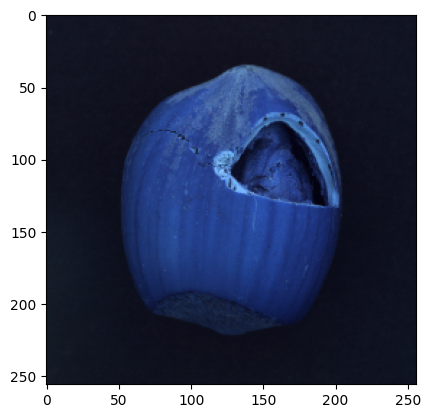

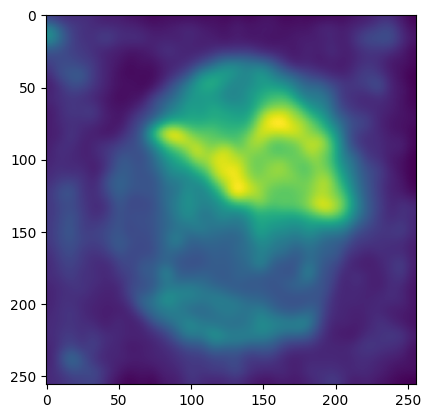

In [ ]:
#normal only 
img,label,gt,idx = testset[0]
img = img.unsqueeze(0)

with torch.no_grad():
    outputs = model(img.to('cuda'))
    score_map = model.get_score_map(outputs)
    
img_show(img[0])
img_show(score_map[0])    

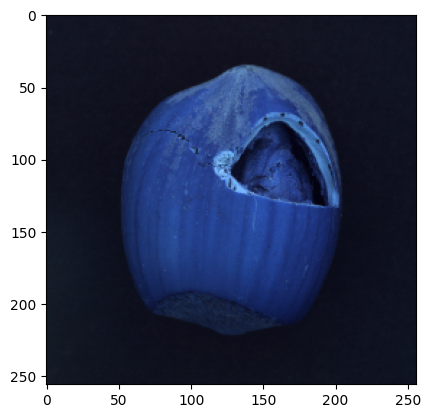

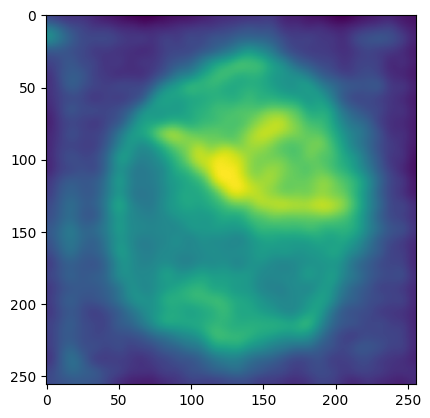

In [ ]:
# 1epoch 
img,label,gt,idx = testset[0]
img = img.unsqueeze(0)

with torch.no_grad():
    outputs = model(img.to('cuda'))
    score_map = model.get_score_map(outputs)
    
img_show(img[0])
img_show(score_map[0])    

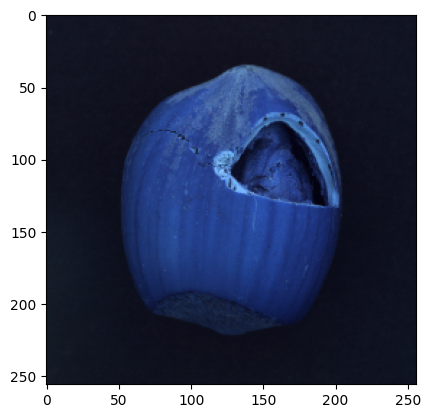

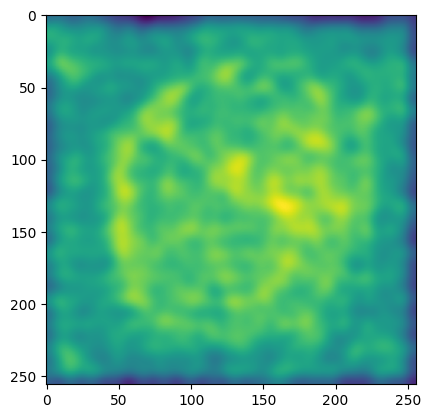

In [ ]:
img,label,gt,idx = testset[0]
img = img.unsqueeze(0)

with torch.no_grad():
    outputs = model(img.to('cuda'))
    score_map = model.get_score_map(outputs)
    
img_show(img[0])
img_show(score_map[0])    

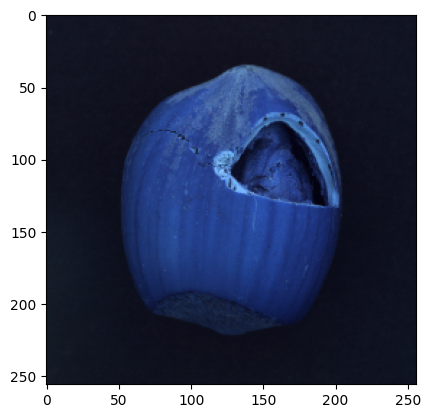

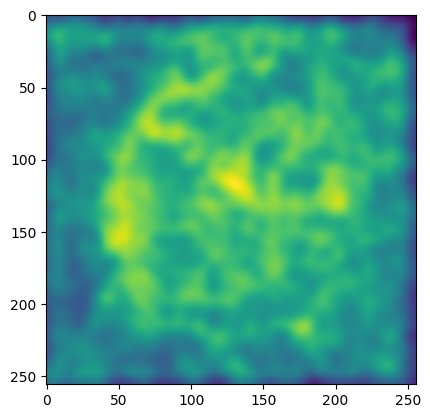

In [ ]:
img,label,gt,idx = testset[0]
img = img.unsqueeze(0)

with torch.no_grad():
    outputs = model(img.to('cuda'))
    score_map = model.get_score_map(outputs)
    
img_show(img[0])
img_show(score_map[0])    

In [ ]:
fig, ax = plt.subplots(3,2, figsize=(10,12))
for i in range(3):
    data = df_melted[(df_melted['level']==f"level{i}")]
    sns.lineplot(
        x = 'epoch',
        y = 'value',
        hue = 'label',
        data = data,
        ax = ax[i][0],
        palette= ['red','blue']
    )

    sns.lineplot(data=data, 
                x="epoch", y="value", 
                hue=0, palette=['red' if l == 'anomaly' else 'blue' for l in data.drop_duplicates(0)['label']],
                ax = ax[i][1])
    ax[i][1].get_legend().remove()
    ax[i][1].set(xlabel=None)
    ax[i][1].set(ylabel=None)
    ax[i][0].set(xlabel=None)
    ax[i][0].set(ylabel='loss')
    ax[i][0].set_title(f'level:{i}')
    


ax[2][0].set_xlabel('Epoch')
ax[2][1].set_xlabel('Epoch')
plt.ylabel("loss")
plt.show()


# T-sne 

In [ ]:
from sklearn.manifold import TSNE 

def make_tsne(embeddings):
    tsne = TSNE(n_components=2, random_state=0)
    low_dimensional_data = tsne.fit_transform(embeddings)
    color = np.where(label_list==1,'red','blue')

    plt.figure(figsize=(7, 6))
    plt.scatter(low_dimensional_data[:, 0], low_dimensional_data[:, 1],
                c = color)
    plt.xlabel('t-SNE feature 1')
    plt.ylabel('t-SNE feature 2')
    plt.title('t-SNE Visualization of High-Dimensional Data')
    plt.show()

In [ ]:
model = refinement.init_model()

# optimizer
optimizer = __import__('torch.optim', fromlist='optim').__dict__[opt_name](model.parameters(), lr=lr, **opt_params)

scheduler = None 

# # prepraring accelerator
model, optimizer, trainloader, testloader, scheduler = accelerator.prepare(
    model, optimizer, trainloader, testloader, scheduler
)

for epoch in range(10):
    d_list = [] 
    e_list = [] 
    label_list = [] 
    for imgs,labels,gts,idxs in trainloader:
        outputs = model(imgs)
        (es, ds) = outputs
        loss   = model.criterion(outputs)
        
        d_list.append(
            [d.detach().cpu().numpy() for d in ds]
        )
        
        e_list.append(
            [e.detach().cpu().numpy() for e in es]
        )
        
        label_list.extend(
            labels.tolist()
        )
        
        # optimizer.zero_grad()
        # accelerator.backward(loss)
        # optimizer.step()
        
    label_list = np.array(label_list)    

    embeddings = np.concatenate([d[1].reshape(d[1].shape[0],-1) for d in d_list])
    make_tsne(embeddings)
    break 

In [ ]:
from common_utils import * 
import torch.nn.functional as F 

device = 'cuda'
model = refinement.init_model()
patchprocess = PatchProcess()
model.to(device)

feature_list = [] 
label_list = [] 
for imgs, labels, gts, idxs in trainloader:
    features = model.encoder(imgs.to(device))
    features = patchprocess(features)
    labels_ = torch.vstack([torch.full((64, 64), value).unsqueeze(0) for value in labels]).reshape(-1)
    
    feature_list.append(features.detach().cpu())
    label_list.append(labels_.detach().cpu())
    break 
feature_list = torch.concat(feature_list)
label_list = torch.concat(label_list)    

# Test 

In [ ]:
import torch.nn as nn 
model = refinement.init_model()
stem = nn.Sequential(    
                nn.ConvTranspose2d(256,64,kernel_size=3,stride=2,padding=1,output_padding=1,dilation=1),
                nn.ReLU(),
                nn.BatchNorm2d(64),
                nn.ConvTranspose2d(64,3,kernel_size=7,stride=2,padding=3, bias=False, output_padding=1)    
        )
# optimizer
param = list(model.parameters()) + list(stem.parameters())
# param = list(model.parameters()) 
optimizer = __import__('torch.optim', fromlist='optim').__dict__[opt_name](param, lr=lr, **opt_params)

scheduler = None 

re_cri = torch.nn.MSELoss()

# # prepraring accelerator
stem, model, optimizer, trainloader, testloader, scheduler = accelerator.prepare(
    stem, model, optimizer, trainloader, testloader, scheduler
)

for epoch in range(30):
    for imgs,labels,gts in trainloader:
        outputs = model(imgs)
        (es, ds) = outputs
        loss   = model.criterion(outputs)
        
        x_ = stem(es[0]* 0.9 + ds[0] * 0.1)
        
        re_loss = re_cri(x_,imgs)

        loss = loss * 0.9 + 0.1 * re_loss 
        
        optimizer.zero_grad()
        accelerator.backward(loss)
        optimizer.step()
        


In [ ]:
# recon half and half 
from torchmetrics import AUROC 
pixel_auroc = AUROC()
image_auroc = AUROC()

with torch.no_grad():
    for imgs, labels, gts in testloader:
        outputs = model(imgs)
        score_map = model.get_score_map(outputs).detach().cpu()
        score = score_map.reshape(score_map.shape[0],-1).max(-1)[0]

        # Stack Scoring for auroc 
        pixel_auroc.update(score_map.flatten(), gts.flatten().type(torch.int8).detach().cpu())
        image_auroc.update(score, labels.detach().cpu())
print(pixel_auroc.compute(), image_auroc.compute())        

/usr/local/lib/python3.8/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


tensor(0.9926) tensor(0.9268)


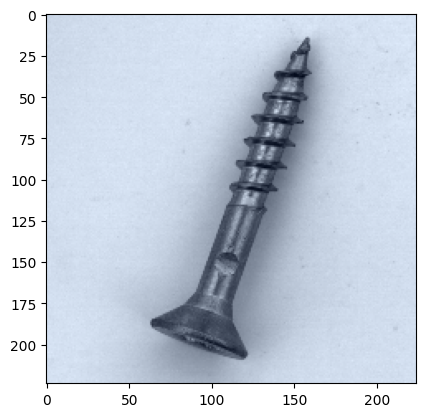

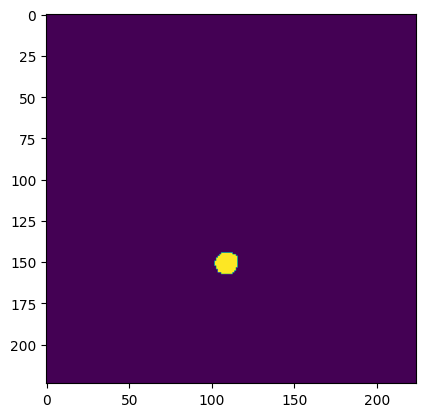

In [ ]:
img_show(imgs[0])
img_show(gts[0])

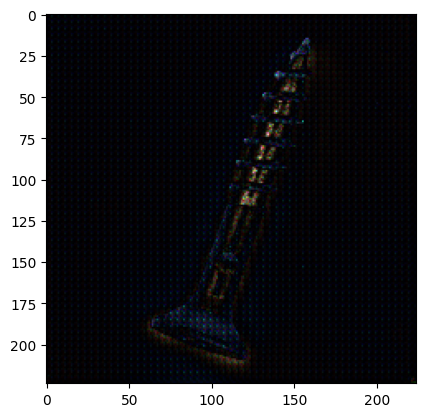

In [ ]:
(es,ds) = outputs 
x_ = stem(ds[0])[0]
x = imgs[0][0]
img_show((x - x_ )**2)

In [ ]:
# # recon half and half 
# x_ = stem(es[0]* 0.9 + ds[0] * 0.1)
        
#         re_loss = re_cri(x_,imgs)

#         loss = loss  + 0.1 * re_loss 
from torchmetrics import AUROC 
pixel_auroc = AUROC()
image_auroc = AUROC()

with torch.no_grad():
    for imgs, labels, gts in testloader:
        outputs = model(imgs)
        score_map = model.get_score_map(outputs).detach().cpu()
        score = score_map.reshape(score_map.shape[0],-1).max(-1)[0]

        # Stack Scoring for auroc 
        pixel_auroc.update(score_map.flatten(), gts.flatten().type(torch.int8).detach().cpu())
        image_auroc.update(score, labels.detach().cpu())
print(pixel_auroc.compute(), image_auroc.compute())        

/usr/local/lib/python3.8/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


tensor(0.9914) tensor(0.9246)


In [ ]:
# recon half and half 
from torchmetrics import AUROC 
pixel_auroc = AUROC()
image_auroc = AUROC()

with torch.no_grad():
    for imgs, labels, gts in testloader:
        outputs = model(imgs)
        score_map = model.get_score_map(outputs).detach().cpu()
        score = score_map.reshape(score_map.shape[0],-1).max(-1)[0]

        # Stack Scoring for auroc 
        pixel_auroc.update(score_map.flatten(), gts.flatten().type(torch.int8).detach().cpu())
        image_auroc.update(score, labels.detach().cpu())
print(pixel_auroc.compute(), image_auroc.compute())        

/usr/local/lib/python3.8/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


tensor(0.9655) tensor(0.8466)


In [ ]:
# only recon 
from torchmetrics import AUROC 
pixel_auroc = AUROC()
image_auroc = AUROC()

with torch.no_grad():
    for imgs, labels, gts in testloader:
        outputs = model(imgs)
        score_map = model.get_score_map(outputs).detach().cpu()
        score = score_map.reshape(score_map.shape[0],-1).max(-1)[0]

        # Stack Scoring for auroc 
        pixel_auroc.update(score_map.flatten(), gts.flatten().type(torch.int8).detach().cpu())
        image_auroc.update(score, labels.detach().cpu())
print(pixel_auroc.compute(), image_auroc.compute())        

/usr/local/lib/python3.8/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


tensor(0.9375) tensor(0.7894)


In [ ]:
# default 
from torchmetrics import AUROC 
pixel_auroc = AUROC()
image_auroc = AUROC()

with torch.no_grad():
    for imgs, labels, gts in testloader:
        outputs = model(imgs)
        score_map = model.get_score_map(outputs).detach().cpu()
        score = score_map.reshape(score_map.shape[0],-1).max(-1)[0]

        # Stack Scoring for auroc 
        pixel_auroc.update(score_map.flatten(), gts.flatten().type(torch.int8).detach().cpu())
        image_auroc.update(score, labels.detach().cpu())
print(pixel_auroc.compute(), image_auroc.compute())        

/usr/local/lib/python3.8/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


tensor(0.9927) tensor(0.9304)


tensor(0.9741) tensor(0.7769)
